In [164]:
from __future__ import annotations
import numpy as np
import pandas as pd
from dataclasses import dataclass

# --- your existing schema (raw -> canonical) ---
erp_cols = {
    'document_number': 'document_number',
    'debit_credit': 'debit_credit',
    'date': 'date',
    'amount': 'amount',
    'quantity': 'quantity',
    'account_name': 'account_id', 
    'product_id': 'product_id',
    'procurement_id': 'procurement_id',
    'service_id': 'service_id',
    'vendor_name': 'vendor_id',  
    'customer_name': 'customer_id'
}

# ---------- schema helpers ----------
@dataclass(frozen=True)
class Schema:
    mapping: dict

    @property
    def inverse(self) -> dict:
        return {v: k for k, v in self.mapping.items()}

    # canonical accessors (auto-expand as you add fields)
    @property
    def document_number(self): return 'document_number'
    @property
    def debit_credit(self):    return 'debit_credit'
    @property
    def date(self):            return 'date'
    @property
    def amount(self):          return 'amount'
    @property
    def quantity(self):        return 'quantity'
    @property
    def account_id(self):      return 'account_id'
    @property
    def product_id(self):      return 'product_id'
    @property
    def procurement_id(self):  return 'procurement_id'
    @property
    def service_id(self):      return 'service_id'
    @property
    def vendor_id(self):       return 'vendor_id'
    @property
    def customer_id(self):     return 'customer_id'

S = Schema(mapping=erp_cols)

def normalize_df(df: pd.DataFrame, schema: Schema = S) -> pd.DataFrame:
    """
    Rename df columns from raw/source names -> canonical names (per schema).
    Safe if some columns aren't present.
    """
    return df.rename(columns={k: v for k, v in schema.mapping.items() if k in df.columns})

def denormalize_df(df: pd.DataFrame, schema: Schema = S) -> pd.DataFrame:
    """
    Optionally map canonical -> original source names (if you need to return in the raw format).
    """
    inv = schema.inverse
    return df.rename(columns={k: v for k, v in inv.items() if k in df.columns})

# ---------- your functions rewritten to use the schema ----------
def estimate_costs_from_payroll(
    df_pay: pd.DataFrame,
    product_multiplier: float = 3,
    service_multiplier: float = 1.5,
    overhead_multiplier: float = 0.2,
    revenue_multiplier: float = 7,
    schema: Schema = S,
) -> dict:
    """
    Estimate total product, service, and overhead costs based on payroll data.
    Expects df_pay to contain a 'line_id' column and an 'amount' (canonical) column.
    """
    df_pay = normalize_df(df_pay, schema)
    temp_df = df_pay[df_pay.get("line_id", pd.Series(index=df_pay.index)).eq("Monthly-pay")]
    total_payroll = temp_df[schema.amount].sum()

    return {
        "estimated_payroll": total_payroll,
        "estimated_product": round(total_payroll * product_multiplier),
        "estimated_service": round(total_payroll * service_multiplier),
        "estimated_overhead": round(total_payroll * overhead_multiplier),
        "estimated_revenue": round(total_payroll * revenue_multiplier),
    }

def assign_split_count(
    df_spend: pd.DataFrame,
    *,
    target_doc_value: float | None = None,   # if None, use per-row 'target_doc_value' column
    max_lines_per_doc: int = 25,
    cap_factor: float = 1.15,
    alpha_prop: float = 1.5,
    noise_sigma: float = 0.20,
    schema: Schema = S,
) -> pd.DataFrame:
    rng = np.random.default_rng(42)
    df = normalize_df(df_spend, schema).copy()

    # --- required columns
    amt_col = next((c for c in ("total_amount","annual_spend","total_ammount","total") if c in df.columns), None)
    if amt_col is None: raise ValueError("Need a total amount column.")
    if "unit_price" not in df.columns: raise ValueError("Missing 'unit_price'.")
    if "proportionality" not in df.columns: raise ValueError("Missing 'proportionality'.")

    # --- coerce numerics robustly
    total = pd.to_numeric(df[amt_col], errors="coerce").fillna(0.0).clip(lower=0.0)
    u     = pd.to_numeric(df["unit_price"], errors="coerce").replace([np.inf,-np.inf], np.nan).fillna(1.0).clip(lower=1.0)
    prop  = pd.to_numeric(df["proportionality"], errors="coerce").fillna(0.5).clip(0.0, 1.0)

    # --- target doc value (per-row if present; otherwise broadcast param)
    if target_doc_value is None and "target_doc_value" in df.columns:
        tgt = pd.to_numeric(df["target_doc_value"], errors="coerce")
    else:
        tgt = pd.Series(float(target_doc_value) if target_doc_value is not None else np.nan, index=df.index)

    # sanitize tgt: replace non-finite or <=0 with a fallback
    # fallback: half of feasibility cap (keeps docs well under cap), min 1.0
    doc_cap = cap_factor * u * max_lines_per_doc
    tgt_fallback = (doc_cap / 2.0).clip(lower=1.0)
    tgt = tgt.where(np.isfinite(tgt) & (tgt > 0), tgt_fallback)

    # --- feasibility: min docs so no doc exceeds cap
    docs_min_for_cap = np.ceil(total / doc_cap.replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(1).astype(int)

    # --- base docs from target size (NaN/∞ safe)
    base_div = (total / tgt).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    base_docs = np.ceil(base_div).astype(int).clip(lower=1)

    # --- adjust by proportionality + mild noise
    adj_factor = 1.0 + alpha_prop * (1.0 - prop)
    noise = np.exp(rng.normal(0.0, noise_sigma, size=len(df)))
    n_docs = np.ceil(base_docs * adj_factor * noise).astype(int)

    # --- respect feasibility cap & ensure >=1
    n_docs = np.maximum(n_docs, docs_min_for_cap).clip(lower=1)

    # --- estimate lines and clamp
    est_total_lines = np.ceil(total / u).replace([np.inf,-np.inf], np.nan).fillna(1).astype(int).clip(lower=1)
    avg_lines_per_doc = np.clip(np.ceil(est_total_lines / n_docs), 1, max_lines_per_doc).astype(int)

    # --- write outputs
    df["n_docs"] = n_docs
    df["avg_lines_per_doc"] = avg_lines_per_doc
    df["doc_value_cap"] = np.round(doc_cap, 2)
    df["num_splits"] = df["n_docs"]
    return df


def plan_docs_for_items(
    df_spend: pd.DataFrame,
    df_date: pd.DataFrame,
    *,
    schema_date_fn,                 # e.g. schema_constant_balanced
    target_doc_value: float = 25_000,
    max_lines_per_doc: int = 25,
    schema: Schema = S,
) -> pd.DataFrame:
    """
    Uses n_docs/avg_lines_per_doc (from assign_split_count) to create per-item doc shells:
    one row per planned document with (date, doc_value, n_lines).
    """
    rng = np.random.default_rng(42)
    df = normalize_df(df_spend, schema).copy()

    # discover total amount column
    amt_col = next((c for c in ("total_amount","annual_spend","total_ammount","total") if c in df.columns), None)
    if amt_col is None:
        raise ValueError("Missing total amount column (total_amount/annual_spend).")
    if "unit_price" not in df.columns: raise ValueError("Missing unit_price.")
    if "n_docs" not in df.columns:     raise ValueError("Run assign_split_count first (needs n_docs).")

    rows = []
    for _, r in df.iterrows():
        total = float(r[amt_col])
        if total <= 0: 
            continue

        n_docs  = int(max(1, r.get("n_docs", 1)))
        unit_p  = float(r["unit_price"]) if r["unit_price"] else 1.0
        avg_lp  = int(max(1, min(r.get("avg_lines_per_doc", max_lines_per_doc), max_lines_per_doc)))
        item    = r.get("item_name")
        stype   = r.get("source_type","")
        p_id    = r.get(schema.product_id)
        pr_id   = r.get(schema.procurement_id)
        s_id    = r.get(schema.service_id)

        # date plan (balanced): n_docs dates per item
        dates = schema_date_fn(df_date=df_date, size=n_docs, noise_pct=0.10, ensure_quarter_balance=True, business_days_only=True, random_state=42).to_list()

        # value plan: split total into n_docs, cap with target_doc_value (softly)
        w = rng.dirichlet(np.ones(n_docs))
        doc_vals = np.round(w * total, 2)
        # ensure exact sum
        doc_vals[-1] = round(total - float(doc_vals[:-1].sum()), 2)

        # lines per doc: bounded by unit price & max_lines
        n_lines = np.clip(np.ceil(doc_vals / max(unit_p, 1.0)).astype(int), 1, avg_lp)

        for dt, dv, nl in zip(dates, doc_vals, n_lines):
            rows.append({
                "item_name": item,
                "source_type": stype,
                "date": pd.to_datetime(dt),
                "doc_value": float(dv),
                "n_lines": int(nl),
                "unit_price": unit_p,
                schema.product_id: p_id,
                schema.procurement_id: pr_id,
                schema.service_id: s_id,
            })

    return pd.DataFrame(rows)

def materialize_lines_from_plan(
    df_docplan: pd.DataFrame,
    df_mapping: pd.DataFrame,
    *,
    schema: Schema = S,
) -> pd.DataFrame:
    """
    For each planned doc (row), split doc_value into n_lines, assign mapping rows,
    and set sign by source_type. Returns ERP lines in canonical columns.
    """
    rng = np.random.default_rng(43)
    df_map = normalize_df(df_mapping, schema)

    out = []
    for _, r in df_docplan.iterrows():
        item_name = r.get("item_name")
        stype     = str(r.get("source_type","")).lower()
        doc_val   = float(r.get("doc_value", 0.0))
        n_lines   = int(max(1, r.get("n_lines", 1)))
        unit_p    = float(r.get("unit_price", 1.0))

        # split doc_value across lines (Dirichlet → round cents → fix drift)
        w = rng.dirichlet(np.ones(n_lines))
        line_vals = np.round(w * abs(doc_val), 2)
        line_vals[-1] = round(abs(doc_val) - float(line_vals[:-1].sum()), 2)

        sign = -1.0 if stype in ("service","procurement","overhead") else 1.0
        line_vals *= sign

        # mapping sample (per line) for the item
        m = df_map[df_map.get("item_name", pd.Series(dtype=object)).eq(item_name)]
        if m.empty:
            m = pd.DataFrame([{schema.account_id: None, "account_name": None, "item_name": item_name}])
        m = m.sample(n=n_lines, replace=True, random_state=43).reset_index(drop=True)

        # build entries
        for amt, (_, map_row) in zip(line_vals, m.iterrows()):
            qty = max(1.0, np.ceil(abs(amt) / max(unit_p, 1.0)))
            entry = {
                schema.debit_credit: "Credit" if sign > 0 else "Debit",
                schema.amount: float(amt),
                schema.quantity: float(qty),
                schema.account_id: map_row.get(schema.account_id), 
                "unit_price": unit_p,
                "item_name": item_name,
                "source_type": r.get("source_type",""),
                schema.date: pd.to_datetime(r["date"]),
                schema.product_id: r.get(schema.product_id),
                schema.procurement_id: r.get(schema.procurement_id),
                schema.service_id: r.get(schema.service_id),
            }
            for opt in ("department_name","customer_name","vendor_name",schema.customer_id, schema.vendor_id):
                if opt in map_row and pd.notna(map_row[opt]):
                    entry[opt] = map_row[opt]
            out.append(entry)

    return pd.DataFrame(out)


def pre_split_spend_lines(
    df_spend: pd.DataFrame,
    df_mapping: pd.DataFrame,
    n_lines_per_item: int = 50,
    schema: Schema = S,
) -> pd.DataFrame:
    """
    Splits each item (product or service) into journal lines,
    with expenses as negative and revenues as positive values.
    Requires df_mapping to have: ['item_name','account_id','account_name'] (canonical or normalized).
    """
    df_spend = normalize_df(df_spend, schema)
    df_mapping = normalize_df(df_mapping, schema)

    line_items: list[dict] = []

    for _, row in df_spend.iterrows():
        item_name = row.get("item_name")
        source_type = row.get("source_type", "")
        total = float(row.get("annual_spend", 0.0))
        unit_price = float(row.get("unit_price", 0.0))

        product_id = row.get(schema.product_id)
        procurement_id = row.get(schema.procurement_id)
        service_id = row.get(schema.service_id)

        weights = np.random.dirichlet(np.ones(n_lines_per_item) * 0.5)
        amounts = weights * total

        mappings = df_mapping[df_mapping.get("item_name", pd.Series(dtype=object)).eq(item_name)]
        if mappings.empty:
            # fallback: if no mapping, create a dummy single-line map to avoid crash
            mappings = pd.DataFrame([{schema.account_id: None, "account_name": None, "item_name": item_name}])

        mappings = mappings.sample(n=n_lines_per_item, replace=True, random_state=42)

        for amt, (_, map_row) in zip(amounts, mappings.iterrows()):
            st = str(source_type).lower()
            if st in ("service", "procurement", "overhead"):
                signed_amount = -round(amt, 2)
            elif st == "product":
                signed_amount = round(amt, 2)
            else:
                signed_amount = round(amt, 2)

            entry = {
                schema.debit_credit: "Credit",
                schema.amount: signed_amount,
                schema.account_id: map_row.get(schema.account_id), 
                "item_name": item_name,
                "unit_price": unit_price,
                "source_type": source_type,
                schema.product_id: product_id,
                schema.procurement_id: procurement_id,
                schema.service_id: service_id,
            }

            # optional passthroughs
            for opt in ("department_name", "customer_name", "vendor_name",
                        schema.customer_id, schema.vendor_id):
                if opt in map_row.index and pd.notna(map_row[opt]):
                    entry[opt] = map_row[opt]

            line_items.append(entry)

    return pd.DataFrame(line_items)



def create_erp_data(
    df_expenses: pd.DataFrame,
    df_expenses_mapping: pd.DataFrame,
    df_document_metadata: pd.DataFrame,
    *,
    generate_dim_date,       
    schema_date,         
    schema: Schema = S,
) -> pd.DataFrame:
    """
    Create ERP journal lines from spend data and mapping.
    Expenses are negative, revenues are positive. No balancing logic.
    """
    df_expenses = normalize_df(df_expenses, schema)
    df_expenses_mapping = normalize_df(df_expenses_mapping, schema)
    df_document_metadata = normalize_df(df_document_metadata, schema)

    df_expenses = assign_split_count(df_expenses, schema=schema)
    df_date = generate_dim_date(year_start=2020, year_end=2025)

    df = pre_split_spend_lines(
        df_spend=df_expenses,
        df_mapping=df_expenses_mapping,
        n_lines_per_item=30,
        schema=schema,
    )

    

    # Assign document number, date, and currency randomly (no balancing)
    # df_document_metadata should contain canonical names now
    if "currency" not in df_document_metadata.columns:
        # create a simple default currency list if missing
        df_document_metadata = df_document_metadata.copy()
        df_document_metadata["currency"] = np.random.choice(["EUR","USD","DKK"], size=len(df_document_metadata), replace=True)

    df["currency"] = np.random.choice(df_document_metadata["currency"], size=len(df), replace=True)

    # document numbers (canonical)
    doc_pool = df_document_metadata.get(schema.document_number)
    if doc_pool is None:
        # synthesize if absent
        doc_pool = pd.Series([f"DOC-{i:06d}" for i in range(max(1, len(df)//10))])
    df[schema.document_number] = np.random.choice(doc_pool, size=len(df), replace=True)

    # dates
    df[schema.date] = schema_date(df_date, size=len(df), noise_pct=0.15)

    # quantities
    df[schema.quantity] = np.ceil(df[schema.amount] / df.get("unit_price", 1).replace({0:1}))
    if df.get(schema.service_id) is not None and df[schema.service_id].isna().all():
        df[schema.amount] = df.get("unit_price", 0) * df[schema.quantity]
    df[schema.quantity] = df[schema.quantity].abs()

    # Final output columns (canonical)
    cols = [
        schema.document_number, schema.date, "currency",
        schema.amount, schema.quantity, schema.debit_credit,
        schema.account_id, schema.product_id, schema.procurement_id, schema.service_id,
    ]
    for opt in ("department_name", "customer_name", "vendor_name", schema.customer_id, schema.vendor_id):
        if opt in df.columns and opt not in cols:
            cols.append(opt)

    return df[[c for c in cols if c in df.columns]]

def compute_target_doc_value_per_item(
    df: pd.DataFrame,
    *,
    unit_price_col: str = "unit_price",
    max_lines_per_doc: int = 25,
    cap_factor: float = 1.15,     # allow small overflow vs strict max_lines
    min_doc_value: float = 5_000, # floor so docs aren’t tiny
    cheap_expensive_log10: tuple[float, float] = (3.0, 6.0),  # 10^3..10^6 price band
    lines_for_band: tuple[int, int] = (12, 2),                # cheap→12 lines, expensive→2 lines
) -> pd.DataFrame:
    """
    Adds per-row:
      - target_doc_value: adaptive target document size
      - doc_value_cap:    hard cap derived from unit_price & max_lines_per_doc
      - desired_lines:    intended lines per doc, before feasibility clamp
    """
    out = df.copy()

    u = out[unit_price_col].astype(float).replace([np.inf, -np.inf], np.nan).fillna(1.0).clip(lower=1.0)
    logu = np.log10(u)

    # Map log10(unit_price) ∈ [cheap, expensive] to desired lines ∈ [cheap_lines, expensive_lines]
    lo, hi = cheap_expensive_log10
    l_lo, l_hi = lines_for_band  # (cheap_lines, expensive_lines)
    desired_lines = np.interp(logu, [lo, hi], [l_lo, l_hi])  # linear in log-space
    desired_lines = np.clip(np.round(desired_lines), 1, max_lines_per_doc).astype(int)

    # Target doc value from desired lines
    target_doc_value = u * desired_lines

    # Hard feasibility cap from max_lines_per_doc
    doc_value_cap = cap_factor * u * max_lines_per_doc

    # Clamp target within [min_doc_value, doc_value_cap]
    target_doc_value = np.clip(target_doc_value, min_doc_value, doc_value_cap)

    out["desired_lines"] = desired_lines
    out["target_doc_value"] = np.round(target_doc_value, 2)
    out["doc_value_cap"] = np.round(doc_value_cap, 2)
    return out

def balance_documents_with_assets(
    df_erp: pd.DataFrame,
    df_accounts: pd.DataFrame,
    tolerance: float = 100.0,
    min_corrections: int = 5,
    max_corrections: int = 20,
    rng: np.random.RandomState | None = None,
    schema: Schema = S,
) -> pd.DataFrame:
    """
    Balances each document so its amount sums to 0 using 'Debit' correction lines from Asset accounts.
    df_accounts must contain at least ['account_id','account_type'] in canonical names (normalize if needed).
    """
    if rng is None:
        rng = np.random.RandomState()

    df = normalize_df(df_erp, schema).copy()
    df_accounts = normalize_df(df_accounts, schema)

    if "account_type" not in df_accounts.columns:
        # try to infer if possible
        raise ValueError("df_accounts must include 'account_type' to pick Asset accounts")

    asset_accounts = df_accounts[df_accounts["account_type"] == "Asset"]
    if asset_accounts.empty:
        return df

    correction_rows = []

    for doc_id, group in df.groupby(schema.document_number):
        imbalance = round(float(group[schema.amount].sum()), 2)  # + => too much debit, - => too much credit
        if abs(imbalance) <= tolerance:
            continue

        sample_row = group.sample(1, random_state=rng).iloc[0]

        correction_sign = -1 if imbalance > 0 else 1
        total_correction = abs(imbalance)

        n_chunks = int(rng.randint(min_corrections, max_corrections + 1))
        weights = rng.dirichlet([1.0] * n_chunks)
        raw = weights * total_correction
        chunk_values = np.round(raw, 2)
        drift = round(total_correction - float(chunk_values[:-1].sum()), 2)
        chunk_values[-1] = drift

        for amt in chunk_values:
            asset_row = asset_accounts.sample(1, random_state=rng).iloc[0]
            signed_amt = correction_sign * float(amt)

            entry = {
                schema.document_number: doc_id,
                schema.debit_credit: "Debit",
                schema.date: sample_row[schema.date],
                schema.amount: signed_amt,
                schema.quantity: -1,
                schema.account_id: asset_row.get(schema.account_id),
                schema.product_id: None,
                schema.procurement_id: None,
                schema.service_id: None,
            }

            for col in ("department_name", "customer_name", "vendor_name", schema.customer_id, schema.vendor_id):
                if col in sample_row.index:
                    entry[col] = sample_row[col]

            correction_rows.append(entry)

    if correction_rows:
        df = pd.concat([df, pd.DataFrame(correction_rows)], ignore_index=True)

    return df


In [165]:
def normalize_df(df: pd.DataFrame, schema: Schema = S) -> pd.DataFrame:
    df = df.copy()

    # --- special case: account_name should become account_id (name wins) ---
    # If a numeric 'account_id' is present too, preserve it in 'account_code'
    if "account_id" in df.columns and "account_name" in df.columns:
        df["account_code"] = df["account_id"]             # keep numeric/code
        df["account_id"] = df["account_name"]             # NAME takes over
        df.drop(columns=["account_name"], inplace=True)
    elif "account_name" in df.columns:
        df.rename(columns={"account_name": "account_id"}, inplace=True)

    # --- the rest of your schema mappings (raw -> canonical) ---
    for src, tgt in schema.mapping.items():
        if src == "account_name":  # already handled
            continue
        if src not in df.columns:
            continue
        if tgt in df.columns and src != tgt:
            # prefer src when present, otherwise keep existing tgt
            df[tgt] = df[src].where(df[src].notna(), df[tgt])
            df.drop(columns=[src], inplace=True)
        else:
            df.rename(columns={src: tgt}, inplace=True)

    # ensure no duplicate column names
    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    return df
    
def align_to_full_schema(
    df: pd.DataFrame,
    *,
    include_vendor: bool = False,
    include_customer: bool = False,
    include_optional: tuple[str, ...] = ("currency", "amount_eur", "Type"),
    schema: Schema = S,
) -> pd.DataFrame:
    base = [
        schema.document_number, schema.debit_credit, schema.date,
        schema.amount, schema.quantity, schema.account_id,
        schema.product_id, schema.procurement_id, schema.service_id,
    ]
    if include_vendor:
        base.append(schema.vendor_id)
    if include_customer:
        base.append(schema.customer_id)

    df_norm = normalize_df(df, schema).copy()

    # 1) drop duplicate column names (keep first)
    df_norm = df_norm.loc[:, ~df_norm.columns.duplicated(keep="first")]

    # 2) build final column order (keep optionals if present)
    keep_optional = [c for c in include_optional if c in df_norm.columns]
    cols = base + keep_optional

    # 3) add any missing required cols as NA
    for c in base:
        if c not in df_norm.columns:
            df_norm[c] = pd.NA

    # 4) return in desired order (only those that exist)
    return df_norm[[c for c in cols if c in df_norm.columns]]


In [228]:
import pandas as pd
import numpy as np
from generators.random_generators import generate_dim_date, generate_document_metadata
from schemas.date_schemas import schema_constant_balanced

def estimate_costs_from_payroll(
    df_pay: pd.DataFrame,
    product_multiplier: float = 3,
    service_multiplier: float = 1.5,
    overhead_multiplier: float = 0.2,
    revenue_multiplier: float = 7,
) -> dict:
    """
    Estimate total product, service, and overhead costs based on payroll data.
    """
    temp_df = df_pay[df_pay["line_id"] == "Monthly-pay"]
    total_payroll = temp_df["amount"].sum()
    total_payroll = total_payroll/10

    return {
        "estimated_payroll": total_payroll,
        "estimated_product": round(total_payroll * product_multiplier),
        "estimated_service": round(total_payroll * service_multiplier),
        "estimated_overhead": round(total_payroll * overhead_multiplier),
        "estimated_revenue": round(total_payroll * revenue_multiplier)
    }


def assign_split_count(
    df_spend: pd.DataFrame,
    non_linear_multiplier: int = 10,
    min_splits: int = 5,
    max_splits: int = 40
) -> pd.DataFrame:
    """
    Assigns 'num_splits' to each product based on proportionality of spend.
    Smaller proportionality → more splits.
    """
    df = df_spend.copy()

    if "proportionality" not in df.columns:
        raise ValueError("Missing 'proportionality' column in df_spend")

    np.random.seed(42)

    inv_weight = 1 - df["proportionality"]
    inv_weight = inv_weight / (inv_weight.max() + 1e-6)

    df["index_rank"] = df.reset_index().index / len(df)
    rank_multiplier = 1 + (df["index_rank"] ** 2) * non_linear_multiplier

    noise = np.random.lognormal(mean=0.0, sigma=0.4, size=len(df))
    raw_splits = inv_weight * noise * rank_multiplier * 3

    normalized = (raw_splits - raw_splits.min()) / (raw_splits.max() - raw_splits.min())
    df["num_splits"] = (min_splits + normalized * (max_splits - min_splits)).round().astype(int)

    df.drop(columns=["index_rank"], inplace=True)
    return df


def pre_split_spend_lines(
    df_spend: pd.DataFrame,
    df_mapping: pd.DataFrame,
    n_lines_per_item: int = 50
) -> pd.DataFrame:
    """
    Splits each item (product or service) into journal lines,
    with expenses as negative and revenues as positive values.
    """
    line_items = []

    for _, row in df_spend.iterrows():
        item_name = row["item_name"]
        source_type = row["source_type"]
        total = row["annual_spend"]
        unit_price = row["unit_price"]

        product_id = row.get("product_id")
        procurement_id = row.get("procurement_id")
        service_id = row.get("service_id")

        weights = np.random.dirichlet(np.ones(n_lines_per_item) * 0.5)
        amounts = weights * total

        mappings = df_mapping[df_mapping["item_name"] == item_name].sample(n=n_lines_per_item, replace=True)

        for amt, (_, map_row) in zip(amounts, mappings.iterrows()):
            if source_type.lower() in ["service", "procurement", "overhead"]:
                signed_amount = -round(amt, 2)
            elif source_type.lower() == "product":
                signed_amount = round(amt, 2)
            else:
                signed_amount = round(amt, 2)

            entry = {
                "type": "Credit",
                "amount": signed_amount,
                "account_id": map_row["account_id"],
                "account_name": map_row["account_name"],
                "item_name": item_name,
                "unit_price": unit_price,
                "source_type": source_type,
                "product_id": product_id,
                "procurement_id": procurement_id,
                "service_id": service_id
            }

            if "department_name" in map_row:
                entry["department_name"] = map_row["department_name"]
            if "customer_name" in map_row:
                entry["customer_name"] = map_row["customer_name"]
            if "vendor_name" in map_row:
                entry["vendor_name"] = map_row["vendor_name"]

            line_items.append(entry)

    return pd.DataFrame(line_items)

def split_qty(
    df: pd.DataFrame,
    df_date: pd.DataFrame,
    *,
    max_qty: int = 100,
    business_days_only: bool = False,
    random_state: int | None = 42,
) -> pd.DataFrame:
    """
    Split rows with quantity > max_qty into multiple rows (<= max_qty).
    Spread split rows evenly across months (per YEAR), assign each split
    a random existing document_number (no suffixes), and preserve totals.

    Pre-step:
        If quantity > 10000, divide both quantity and amount by 100.

    Required df columns: 'document_number','date','amount','quantity'
    Optional: 'unit_price' (if present, amounts are recomputed as unit_price * quantity)
    df_date must have a 'date' column defining the calendar to sample from.
    """
    df = df.copy()

    # --- scale adjustment at the start ---
    if "quantity" in df.columns:
        mask = df["quantity"] > 10000
        df.loc[mask, "quantity"] = df.loc[mask, "quantity"] / 100
        df.loc[mask, "amount"]   = df.loc[mask, "amount"] / 100

    rng = np.random.default_rng(random_state)
    cols = df.columns.tolist()
    out_rows = []

    # --- build business-day calendar grouped by Year-Month ---
    cal = pd.DataFrame({"date": pd.to_datetime(df_date["date"])})
    if business_days_only:
        cal = cal[cal["date"].dt.dayofweek < 5]  # Mon-Fri only
    cal["YM"] = cal["date"].dt.to_period("M")
    dates_by_month: dict[pd.Period, np.ndarray] = {
        ym: grp["date"].values for ym, grp in cal.groupby("YM")
    }

    # global per-year month usage to keep splits even
    usage: dict[int, dict[pd.Period, int]] = {}

    def choose_month_for_year(year: int) -> pd.Period:
        # months that exist in calendar for this year
        candidates = sorted([ym for ym in dates_by_month.keys() if ym.start_time.year == year])
        if not candidates:
            candidates = sorted(dates_by_month.keys())
            if not candidates:
                return pd.Timestamp(year=year, month=1, day=1).to_period("M")

        usage.setdefault(year, {})
        for ym in candidates:
            usage[year].setdefault(ym, 0)

        ym_pick = min(candidates, key=lambda m: usage[year][m])
        usage[year][ym_pick] += 1
        return ym_pick

    def pick_date_in_month(ym: pd.Period, fallback_date: pd.Timestamp) -> pd.Timestamp:
        arr = dates_by_month.get(ym)
        if arr is not None and len(arr) > 0:
            return pd.Timestamp(arr[rng.integers(0, len(arr))])
        # fallback to same year if no days in that month
        year_mask = cal["date"].dt.year == ym.start_time.year
        cand = cal.loc[year_mask, "date"].values
        if len(cand) > 0:
            return pd.Timestamp(cand[rng.integers(0, len(cand))])
        return pd.Timestamp(fallback_date)

    doc_pool = df["document_number"].dropna().astype(str).unique()
    has_unit_price = "unit_price" in df.columns

    for _, row in df.iterrows():
        qty = float(row["quantity"])
        amt = float(row["amount"])
        orig_date = pd.to_datetime(row["date"])
        year = orig_date.year

        if qty <= max_qty:
            out_rows.append(row.to_dict())
            continue

        # quantities per split
        n_parts = int(np.ceil(qty / max_qty))
        qty_splits = [max_qty] * (n_parts - 1) + [qty - max_qty * (n_parts - 1)]

        # amounts per split
        if has_unit_price and pd.notna(row["unit_price"]):
            unit_price = float(row["unit_price"])
            split_amts = [unit_price * q for q in qty_splits]
            split_amts[-1] += amt - sum(split_amts)  # drift correction
        else:
            split_amts = [amt * (q / qty) for q in qty_splits]
            split_amts[-1] += amt - sum(split_amts)

        for q_i, a_i in zip(qty_splits, split_amts):
            ym = choose_month_for_year(year)
            new_date = pick_date_in_month(ym, orig_date)
            new_doc = str(rng.choice(doc_pool)) if len(doc_pool) else row["document_number"]

            child = row.to_dict()
            child["document_number"] = new_doc
            child["date"] = new_date
            child["quantity"] = q_i
            child["amount"] = a_i
            out_rows.append(child)

    return pd.DataFrame(out_rows, columns=cols)

def balance_documents_with_assets(
    df_erp: pd.DataFrame,
    df_accounts: pd.DataFrame,
    tolerance: float = 100.0,
    min_corrections: int = 5,
    max_corrections: int = 20,
    rng: np.random.RandomState | None = None,
) -> pd.DataFrame:
    """
    Balances each document_number so its amount sums to 0,
    using a random number (4..20 by default) of 'Debit' correction lines
    drawn from Asset accounts.

    Args:
        df_erp: ERP journal data (must have: document_number, amount, date)
        df_accounts: Dim table with at least ['account_id','account_type'] (Asset accounts used)
        tolerance: allowable absolute imbalance without correction (in posting currency units)
        min_corrections: minimum number of correction lines per imbalanced document
        max_corrections: maximum number of correction lines per imbalanced document
        rng: optional np.random.RandomState for reproducibility

    Returns:
        Balanced ERP DataFrame
    """
    if rng is None:
        rng = np.random.RandomState()

    df = df_erp.copy()
    asset_accounts = df_accounts[df_accounts["account_type"] == "Asset"]
    if asset_accounts.empty:
        # nothing to correct with
        return df

    correction_rows = []

    for doc_id, group in df.groupby("document_number"):
        imbalance = round(float(group["amount"].sum()), 2)  # + => too much debit, - => too much credit
        if abs(imbalance) <= tolerance:
            continue

        # Sample a representative row for metadata propagation
        sample_row = group.sample(1, random_state=rng).iloc[0]

        # Sign we need to apply to each chunk to offset the imbalance
        # If imbalance > 0 (too much debit), we need negative correction; else positive.
        correction_sign = -1 if imbalance > 0 else 1
        total_correction = abs(imbalance)

        # Random number of correction lines between 4 and 20
        n_chunks = int(rng.randint(min_corrections, max_corrections + 1))

        # Split into n_chunks using Dirichlet; round to cents; fix last for exact sum
        weights = rng.dirichlet([1.0] * n_chunks)
        raw = weights * total_correction

        # round to cents
        chunk_values = np.round(raw, 2)

        # Adjust last chunk to hit exact total (avoid rounding drift)
        drift = round(total_correction - float(chunk_values[:-1].sum()), 2)
        chunk_values[-1] = drift

        # Guard: if rounding made any zero chunks and you dislike that, jitter them slightly
        # (optional; commented out)
        # for i, v in enumerate(chunk_values):
        #     if v == 0 and total_correction >= 0.01:
        #         chunk_values[i] = 0.01
        # # re-fix last
        # chunk_values[-1] = round(total_correction - float(chunk_values[:-1].sum()), 2)

        for amt in chunk_values:
            asset_row = asset_accounts.sample(1, random_state=rng).iloc[0]
            signed_amt = correction_sign * float(amt)

            entry = {
                "document_number": doc_id,
                "debit_credit": "Debit",  # keep your original label choice
                "date": sample_row["date"],
                "amount": signed_amt,     # sign carries the balancing direction
                "quantity": -1,
                "account_id": asset_row["name"],  # <- fixed from ["name"]
                "product_id": None,
                "procurement_id": None,
                "service_id": None,
            }

            # copy context fields if present
            for col in ("department_name", "customer_name", "vendor_name"):
                if col in sample_row.index:
                    entry[col] = sample_row[col]

            correction_rows.append(entry)

    if correction_rows:
        df = pd.concat([df, pd.DataFrame(correction_rows)], ignore_index=True)

    return df

def create_erp_data(
    df_expenses: pd.DataFrame,
    df_expenses_mapping: pd.DataFrame,
    df_document_metadata: pd.DataFrame,
    date_schema,
) -> pd.DataFrame:
    """
    Create ERP journal lines from spend data and mapping.
    Expenses are negative, revenues are positive. No balancing logic.
    """
    df_expenses = assign_split_count(df_expenses)
    df_date = generate_dim_date(year_start=2022, year_end=2025)
    
    df = pre_split_spend_lines(
        df_spend=df_expenses,
        df_mapping=df_expenses_mapping,
        n_lines_per_item=20
    )

    df[["date", "amount"]] = date_schema(
        df_date=df_date,
        amounts=df["amount"],
        noise_pct=0.05,
        random_state=42,
    )

    # Assign document number, date, and currency randomly (no balancing)
    df["currency"] = np.random.choice(df_document_metadata["currency"], size=len(df), replace=True)
    df["document_number"] = np.random.choice(df_document_metadata["document_number"], size=len(df), replace=True)

    df['quantity'] = np.ceil(df['amount'] / df['unit_price'])
    df['quantity'] = abs(df['quantity'])

    df = split_qty(
        df=df,
        df_date=df_date,
        max_qty=100,
        random_state=42,
    )

    df['amount'] = df['unit_price'] * df['quantity']
    
    # Final output columns
    cols = ['document_number', 'date', 'currency', 'amount', 'quantity', 'unit_price', 'type',
            'account_id', 'account_name', 'product_id', 'procurement_id', 'service_id']

    if "department_name" in df.columns:
        cols.append("department_name")
    if "customer_name" in df.columns:
        cols.append("customer_name")
    if "vendor_name" in df.columns:
        cols.append("vendor_name")


    return df[cols]

In [229]:
# IF service id is not nan, times unitprice by 1000: 


# --- FIXED constant schema ---
def schema_constant_balanced(
    df_date: pd.DataFrame,
    amounts: pd.Series,
    *,
    noise_pct: float = 0.0,          # 0 = perfectly equal; set e.g. 0.05 for mild variation
    business_days_only: bool = True,
    random_state: int | None = None,
    balance_mode: str = "abs",        # "abs" or "signed"
):
    """
    Evenly distribute rows and monthly totals across the date span in `df_date`.

    - Ensures each month with target weight receives >=1 row (when n >= #months).
    - Preserves the *grand total* exactly.
    - Equalizes per-month totals (absolute or signed), with optional light noise.
    - Samples days uniformly within each month (no duplicates unless needed).
    """
    rng = np.random.default_rng(random_state)
    n = int(len(amounts))

    all_dates = pd.to_datetime(df_date["date"]).sort_values().values
    if len(all_dates) == 0 or n == 0:
        return pd.DataFrame({"date": pd.to_datetime([]), "amount": []})

    # 1) Unique month grid across the span
    uniq_months = _month_span_from_dates(all_dates)   # PeriodIndex[M]
    month_ts    = uniq_months.to_timestamp()
    m = len(uniq_months)

    # 2) Target month weights (near uniform with optional log-normal noise)
    if noise_pct and noise_pct > 0:
        sigma = np.log1p(noise_pct)
        noise = np.exp(rng.normal(0.0, sigma, size=m))
        span_weights = _normalize_pos(noise)
    else:
        span_weights = np.ones(m, dtype=float) / m

    # 3) Allocate row counts per month (guarantee >=1 per month if n >= m)
    if n >= m:
        base = np.ones(m, dtype=int)           # seed 1 row per month
        remaining = n - m
        more = _round_counts_to_sum(span_weights, remaining)
        month_counts = base + more
    else:
        # fewer rows than months: choose which months get rows by weight
        month_counts = np.zeros(m, dtype=int)
        take_idx = rng.choice(m, size=n, replace=False, p=span_weights)
        for i in take_idx:
            month_counts[i] += 1

    # 4) Pick actual dates within months
    picked = []
    month_index_for_row = []
    for midx, (m_start, cnt) in enumerate(zip(month_ts, month_counts)):
        if cnt <= 0:
            continue
        days = _business_days_in_month(m_start) if business_days_only else _calendar_days_in_month(m_start)
        chosen = _pick_days(days, cnt, rng)
        picked.append(chosen)
        month_index_for_row.extend([midx] * cnt)

    dates = pd.DatetimeIndex(np.concatenate(picked)) if picked else pd.DatetimeIndex([])
    # keep row order stable with dates paired 1:1 to amounts
    df = pd.DataFrame({"date": dates, "amount": amounts.values})
    df["_month"] = pd.PeriodIndex(df["date"].dt.to_period("M"))

    # 5) Compute current per-month totals and targets on *present* months only
    if balance_mode == "abs":
        cur = df.groupby("_month")["amount"].apply(lambda s: s.abs().sum())
        grand = cur.sum()
    else:
        cur = df.groupby("_month")["amount"].sum()
        grand = cur.sum()

    present_months = cur.index  # subset of uniq_months that actually received rows
    pm = len(present_months)

    # Targets: equal per present month (optionally perturbed by small noise), renormalized to exact grand
    if noise_pct and noise_pct > 0:
        sigma = np.log1p(noise_pct)
        n2 = np.exp(rng.normal(0.0, sigma, size=pm))
        w2 = _normalize_pos(n2)
    else:
        w2 = np.ones(pm, dtype=float) / pm

    tgt = pd.Series(grand * w2, index=present_months)

    # 6) Per-month scaling factors (safe for zeros)
    factors = (tgt / cur.replace(0, np.nan)).fillna(0.0)

    # 7) Apply scaling and return (grand total preserved by construction)
    df["amount"] = df["amount"] * df["_month"].map(factors).astype(float)
    #df.drop(columns=["amount"], inplace=True)
    return df.drop(columns=["_month"])

In [230]:
from generators import random_generators
from modeling import budget
document_metadata_expense = random_generators.generate_document_metadata(n=100, start_index=1000)
document_metadata_products = random_generators.generate_document_metadata(n=2000, start_index=2000)


df_erp_expenses_full = create_erp_data(
    df_expenses=df_erp_expenses,
    df_expenses_mapping=df_map_expenses,
    df_document_metadata=document_metadata_expense,
    date_schema=schema_constant_balanced,
)

df_erp_products_full = create_erp_data(
    df_expenses=df_erp_products,
    df_expenses_mapping=df_map_products,
    df_document_metadata=document_metadata_products,
    date_schema=schema_constant_balanced,
)

# Full target schema # also currency, amount_eur, Type
full_columns = ['document_number', 'type', 'date', 'amount', 'quantity', 'unit_price', 'account_name', 'product_id', 'procurement_id', 'service_id']
vendor_col = ['vendor_name']
customer_col = ['customer_name']

# Reindex all ERP dataframes to align to full schema
df_expenses_full = df_erp_expenses_full.reindex(columns=full_columns + vendor_col)
df_products_full = df_erp_products_full.reindex(columns=full_columns + customer_col)

rename_cols = {
        'document_number': 'document_number',
        'type': 'debit_credit', 
        'date': 'date',
        'amount': 'amount',
        'quantity': 'quantity',
        'unit_price': 'unit_price',
        'account_name': 'account_id',
        'product_id': 'product_id',
        'procurement_id': 'procurement_id',
        'service_id': 'service_id',
        'vendor_name': 'vendor_id',
        'customer_name': 'customer_id'}
    
df_expenses_full.rename(columns=rename_cols, inplace=True)
df_products_full.rename(columns=rename_cols, inplace=True)

df_erp_all = pd.concat([df_expenses_full, df_products_full], ignore_index=True)

df_erp_all["quantity"] = np.ceil(df_erp_all["quantity"].astype(int))
df_erp_all.loc[df_erp_all['quantity'] == 0, 'quantity'] = 1
df_erp_all["amount"] = np.sign(df_erp_all["amount"]) * df_erp_all["quantity"] * df_erp_all["unit_price"]

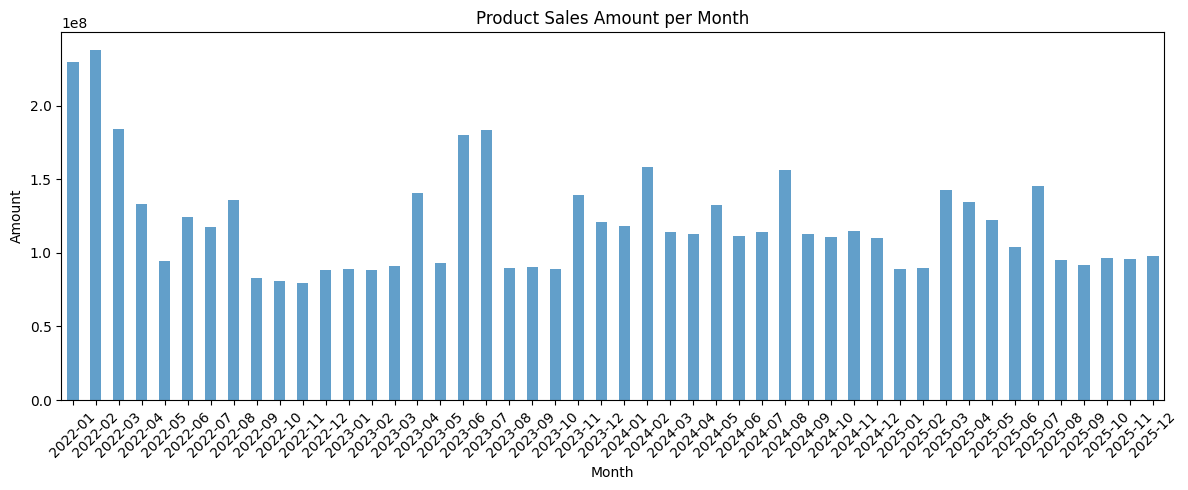

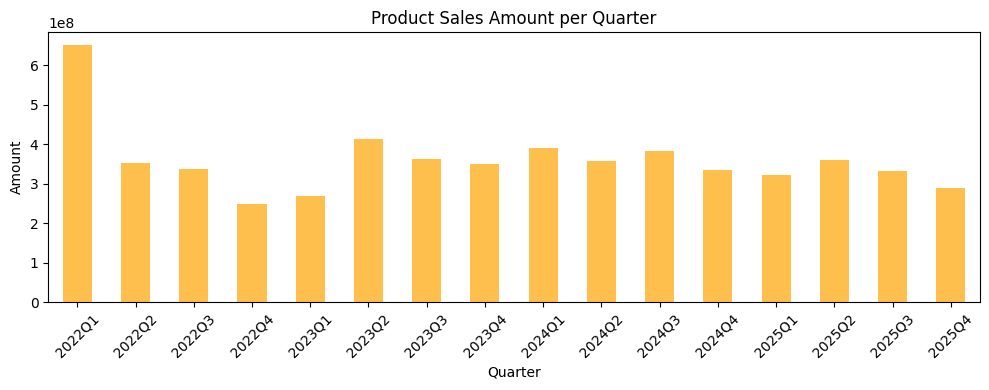

In [231]:
plot_sales_amount_over_time(df_erp_all)

In [92]:
import numpy as np
import pandas as pd

def split_high_quantity_rows(
    df: pd.DataFrame,
    df_date: pd.DataFrame,
    *,
    max_qty: int = 100,
    spread_by: str = "product_id",         # spread “evenly” per this column (e.g., product_id)
    business_days_only: bool = True,
    random_state: int | None = 42,
) -> pd.DataFrame:
    """
    For any row with quantity > max_qty, split into multiple rows with quantity <= max_qty.
    Documents are renumbered as <orig>-01, -02, ...
    Splits are spread across quarters (per YEAR) as evenly as possible for each product (or chosen key).
    Dates are sampled from df_date within the target quarter.

    Required columns in df:
      - 'document_number', 'date', 'amount', 'quantity'
      - optional: 'unit_price' (if present, amounts are recomputed as unit_price * quantity,
        with last split adjusted to keep the original total)
    Required column in df_date:
      - 'date' covering your calendar (used to sample business days per quarter)
    """
    rng = np.random.default_rng(random_state)
    out_rows = []

    # Prepare calendar by quarter
    df_cal = pd.DataFrame({"date": pd.to_datetime(df_date["date"])})
    if business_days_only:
        df_cal = df_cal[df_cal["date"].dt.dayofweek < 5]  # Mon-Fri

    df_cal["YQ"] = df_cal["date"].dt.to_period("Q")
    # Precompute available dates per YQ
    dates_by_yq: dict[pd.Period, np.ndarray] = {
        yq: grp["date"].values for yq, grp in df_cal.groupby("YQ")
    }

    # Helper to pick a date from a quarter (fallback to original date if needed)
    def pick_date_for_yq(yq: pd.Period, fallback_date: pd.Timestamp) -> pd.Timestamp:
        arr = dates_by_yq.get(yq)
        if arr is not None and len(arr) > 0:
            return pd.Timestamp(arr[rng.integers(0, len(arr))])
        # fallback: try any date in same year
        year_mask = (df_cal["date"].dt.year == yq.start_time.year)
        cand = df_cal.loc[year_mask, "date"].values
        if len(cand) > 0:
            return pd.Timestamp(cand[rng.integers(0, len(cand))])
        # last fallback
        return pd.Timestamp(fallback_date)

    # Track per-product-per-year quarter usage counts to spread evenly
    # key -> dict(YQ -> count)
    usage: dict[tuple, dict[pd.Period, int]] = {}

    def choose_yq_for_row(row_key: tuple, year: int) -> pd.Period:
        """
        Choose the quarter in 'year' with the lowest current usage for this product/key.
        If no calendar dates for a quarter exist in that year, ignore that quarter.
        """
        # candidate quarters in that year that exist in calendar
        candidates = sorted([yq for yq in dates_by_yq.keys() if yq.start_time.year == year])
        if not candidates:
            # if year has no calendar, fall back to any YQ available (rare)
            candidates = sorted(dates_by_yq.keys())
            if not candidates:
                # no calendar at all; fake quarters based on fallback
                return pd.Timestamp(year=year, month=3, day=31).to_period("Q")

        usage.setdefault(row_key, {})
        # initialize missing usage counts
        for yq in candidates:
            usage[row_key].setdefault(yq, 0)

        # pick the quarter with the smallest count (tie breaks by order)
        yq_chosen = min(candidates, key=lambda q: usage[row_key][q])
        usage[row_key][yq_chosen] += 1
        return yq_chosen

    # Iterate and split
    cols = df.columns.tolist()
    has_unit_price = "unit_price" in df.columns

    for idx, row in df.iterrows():
        qty = float(row["quantity"])
        if qty <= max_qty:
            # keep as-is
            out_rows.append(row.to_dict())
            continue

        # Split logic
        n_parts = int(np.ceil(qty / max_qty))
        base_qty = int(max_qty)
        qty_splits = [base_qty] * (n_parts - 1) + [int(qty - base_qty * (n_parts - 1))]

        # Amount splitting:
        if has_unit_price and pd.notna(row["unit_price"]):
            # Prefer exact unit_price * qty, adjust last to preserve original total
            unit_price = float(row["unit_price"])
            split_amts = [unit_price * q for q in qty_splits]
            diff = float(row["amount"]) - sum(split_amts)
            split_amts[-1] += diff
        else:
            # proportional split by quantity
            total_amt = float(row["amount"])
            split_amts = [total_amt * (q / qty) for q in qty_splits]
            # adjust last for rounding drift
            split_amts[-1] += total_amt - sum(split_amts)

        # Build per-product key for spreading (default to NaN-safe tuple)
        key_val = row.get(spread_by, None)
        year = pd.Timestamp(row["date"]).year
        key = (spread_by, key_val, year)

        # Make child rows
        orig_doc = str(row["document_number"])
        for i, (q_i, a_i) in enumerate(zip(qty_splits, split_amts), start=1):
            yq = choose_yq_for_row(key, year)
            new_date = pick_date_for_yq(yq, pd.Timestamp(row["date"]))
            new_doc = f"{orig_doc}"

            child = row.to_dict()
            child["document_number"] = new_doc
            child["date"] = new_date
            child["quantity"] = q_i
            child["amount"] = a_i
            out_rows.append(child)

    return pd.DataFrame(out_rows, columns=cols)


In [147]:
import numpy as np
import pandas as pd

def split_qty(
    df: pd.DataFrame,
    df_date: pd.DataFrame,
    *,
    max_qty: int = 100,
    business_days_only: bool = False,
    random_state: int | None = 42,
) -> pd.DataFrame:
    """
    Split rows with quantity > max_qty into multiple rows (<= max_qty).
    Spread split rows evenly across months (per YEAR), assign each split
    a random existing document_number (no suffixes), and preserve totals.

    Pre-step:
        If quantity > 10000, divide both quantity and amount by 100.

    Required df columns: 'document_number','date','amount','quantity'
    Optional: 'unit_price' (if present, amounts are recomputed as unit_price * quantity)
    df_date must have a 'date' column defining the calendar to sample from.
    """
    df = df.copy()

    # --- scale adjustment at the start ---
    if "quantity" in df.columns:
        mask = df["quantity"] > 10000
        df.loc[mask, "quantity"] = df.loc[mask, "quantity"] / 100
        df.loc[mask, "amount"]   = df.loc[mask, "amount"] / 100

    rng = np.random.default_rng(random_state)
    cols = df.columns.tolist()
    out_rows = []

    # --- build business-day calendar grouped by Year-Month ---
    cal = pd.DataFrame({"date": pd.to_datetime(df_date["date"])})
    if business_days_only:
        cal = cal[cal["date"].dt.dayofweek < 5]  # Mon-Fri only
    cal["YM"] = cal["date"].dt.to_period("M")
    dates_by_month: dict[pd.Period, np.ndarray] = {
        ym: grp["date"].values for ym, grp in cal.groupby("YM")
    }

    # global per-year month usage to keep splits even
    usage: dict[int, dict[pd.Period, int]] = {}

    def choose_month_for_year(year: int) -> pd.Period:
        # months that exist in calendar for this year
        candidates = sorted([ym for ym in dates_by_month.keys() if ym.start_time.year == year])
        if not candidates:
            candidates = sorted(dates_by_month.keys())
            if not candidates:
                return pd.Timestamp(year=year, month=1, day=1).to_period("M")

        usage.setdefault(year, {})
        for ym in candidates:
            usage[year].setdefault(ym, 0)

        ym_pick = min(candidates, key=lambda m: usage[year][m])
        usage[year][ym_pick] += 1
        return ym_pick

    def pick_date_in_month(ym: pd.Period, fallback_date: pd.Timestamp) -> pd.Timestamp:
        arr = dates_by_month.get(ym)
        if arr is not None and len(arr) > 0:
            return pd.Timestamp(arr[rng.integers(0, len(arr))])
        # fallback to same year if no days in that month
        year_mask = cal["date"].dt.year == ym.start_time.year
        cand = cal.loc[year_mask, "date"].values
        if len(cand) > 0:
            return pd.Timestamp(cand[rng.integers(0, len(cand))])
        return pd.Timestamp(fallback_date)

    doc_pool = df["document_number"].dropna().astype(str).unique()
    has_unit_price = "unit_price" in df.columns

    for _, row in df.iterrows():
        qty = float(row["quantity"])
        amt = float(row["amount"])
        orig_date = pd.to_datetime(row["date"])
        year = orig_date.year

        if qty <= max_qty:
            out_rows.append(row.to_dict())
            continue

        # quantities per split
        n_parts = int(np.ceil(qty / max_qty))
        qty_splits = [max_qty] * (n_parts - 1) + [qty - max_qty * (n_parts - 1)]

        # amounts per split
        if has_unit_price and pd.notna(row["unit_price"]):
            unit_price = float(row["unit_price"])
            split_amts = [unit_price * q for q in qty_splits]
            split_amts[-1] += amt - sum(split_amts)  # drift correction
        else:
            split_amts = [amt * (q / qty) for q in qty_splits]
            split_amts[-1] += amt - sum(split_amts)

        for q_i, a_i in zip(qty_splits, split_amts):
            ym = choose_month_for_year(year)
            new_date = pick_date_in_month(ym, orig_date)
            new_doc = str(rng.choice(doc_pool)) if len(doc_pool) else row["document_number"]

            child = row.to_dict()
            child["document_number"] = new_doc
            child["date"] = new_date
            child["quantity"] = q_i
            child["amount"] = a_i
            out_rows.append(child)

    return pd.DataFrame(out_rows, columns=cols)


In [148]:
df_split = split_qty(
    df=df_erp_all,
    df_date=generate_dim_date(year_start=2020, year_end=2025),
    max_qty=100,
    random_state=42,
)

In [149]:
df_split["quantity"] = np.ceil(df_split["quantity"].astype(int))
df_split["amount"] = df_split["quantity"]*df_split["unit_price"]
df_split.loc[df_split['quantity'] == 0, 'quantity'] = 1

In [162]:
df_split[["date", "amount"]] = schema_constant_balanced(
    df_date=generate_dim_date(year_start=2020, year_end=2025),
    amounts=df_split["amount"],
    noise_pct=0.05,
)

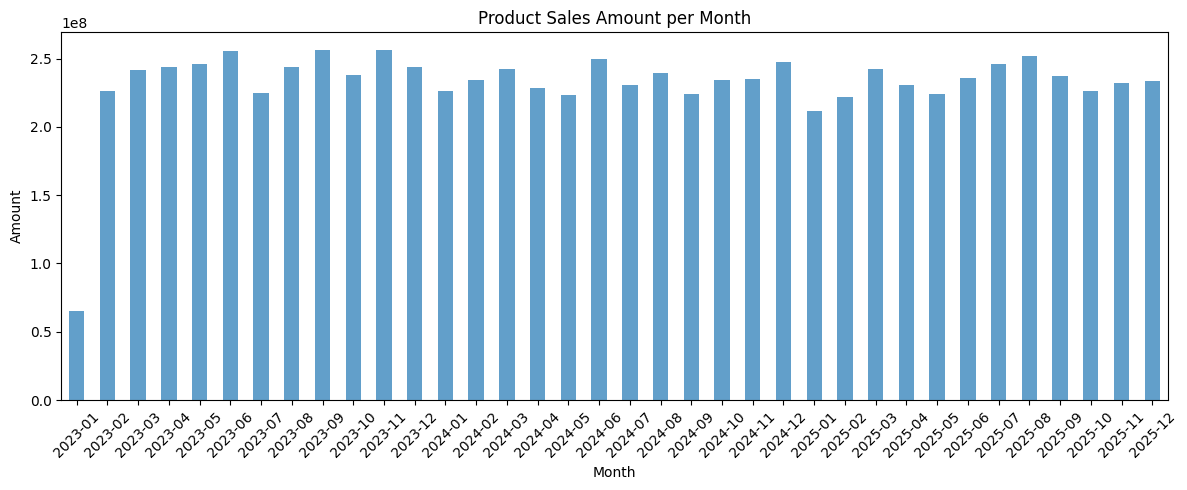

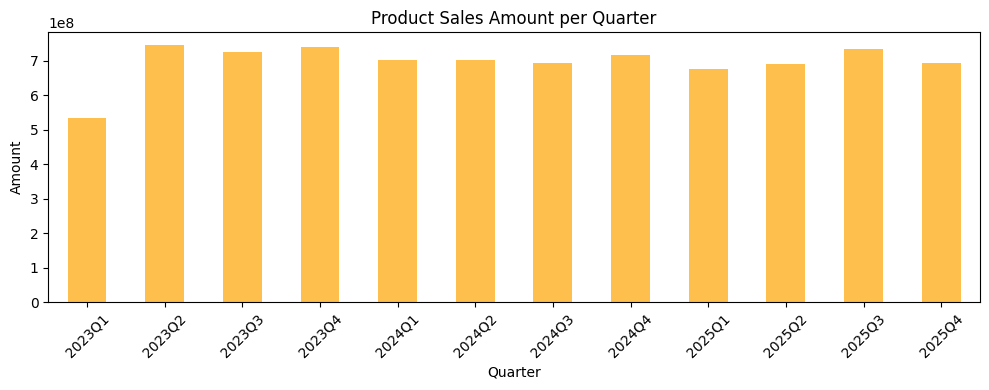

In [163]:
plot_sales_amount_over_time(df_split)

In [126]:
df_split = split_qty(
    df=df_expenses_full,
    df_date=generate_dim_date(year_start=2020, year_end=2025),
    max_qty=100,
    random_state=42,
)

In [127]:
df_split

,document_number,debit_credit,date,amount,quantity,unit_price,account_id,product_id,procurement_id,service_id,vendor_id
0,78001057,Credit,2020-01-01,-5.674407e+05,2.0,250000.0,COGS New Vehicles Purchase,NaN,New passenger vehicles,NaN,Volkswagen AG
1,78001057,Credit,2020-01-01,-2.149179e+05,0.0,250000.0,COGS New Vehicles Purchase,NaN,New passenger vehicles,NaN,Volkswagen AG
2,78001012,Credit,2020-01-02,-2.435034e+03,0.0,250000.0,COGS New Vehicles Purchase,NaN,New passenger vehicles,NaN,Volkswagen AG
3,78001052,Credit,2020-01-02,-2.713194e+06,10.0,250000.0,COGS New Vehicles Purchase,NaN,New passenger vehicles,NaN,Volkswagen AG
4,78001099,Credit,2020-01-03,-4.225902e+04,0.0,250000.0,COGS New Vehicles Purchase,NaN,New passenger vehicles,NaN,Volkswagen AG
...,...,...,...,...,...,...,...,...,...,...,...
8687,78001088,Credit,2025-12-29,-8.021383e+04,0.0,750000.0,Service Subcontractors,NaN,NaN,Annual Pest Control Service Fee,ISS World Services A/S
8688,78001048,Credit,2025-12-29,-1.410374e+05,0.0,750000.0,Service Subcontractors,NaN,NaN,Annual Pest Control Service Fee,ISS World Services A/S
8689,78001043,Credit,2025-12-29,-1.080875e+05,0.0,750000.0,Service Subcontractors,NaN,NaN,Annual Pest Control Service Fee,ISS World Services A/S
8690,78001047,Credit,2025-12-29,-1.769306e+06,2.0,750000.0,Service Subcontractors,NaN,NaN,Annual Pest Control Service Fee,ISS World Services A/S


In [120]:
# IF unit_price
df_expenses_full["unit_price"]

0       250000.0
1       250000.0
2       250000.0
3       250000.0
4       250000.0
          ...   
6595    750000.0
6596    750000.0
6597    750000.0
6598    750000.0
6599    750000.0
Name: unit_price, Length: 6600, dtype: float64

In [111]:
df_split.tail(100)

,document_number,debit_credit,date,amount,quantity,account_id,product_id,procurement_id,service_id,customer_id
53869,78002705,Credit,2025-01-18,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
53870,78002429,Credit,2025-05-14,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
53871,78003806,Credit,2025-09-02,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
53872,78003791,Credit,2025-10-06,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
53873,78003398,Credit,2025-03-02,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
...,...,...,...,...,...,...,...,...,...,...
53964,78002621,Credit,2025-08-01,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
53965,78002075,Credit,2025-11-27,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
53966,78003394,Credit,2025-02-12,95000.0,100.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers
53967,78002445,Credit,2025-04-20,41800.0,44.0,Accessories Sales Revenue,Cargo Liners,NaN,NaN,AutoDrive Retailers


In [95]:
df_expenses_full.sort_values(by=["quantity"], inplace=True)
df_expenses_full.tail(10)

,document_number,debit_credit,date,amount,quantity,account_id,product_id,procurement_id,service_id,vendor_id
1873,78001050,Credit,2021-09-21,-2.681246e+06,1340622.0,COGS New Vehicles Purchase,NaN,Natural gas (m³),NaN,Verdo A/S
2439,78001069,Credit,2022-03-25,-4.067484e+06,1355828.0,COGS Spare Parts,NaN,Staple refills,NaN,Lyreco Danmark A/S
2481,78001099,Credit,2022-04-07,-1.103830e+06,1576900.0,COGS New Vehicles Purchase,NaN,Paper clips,NaN,Lyreco Danmark A/S
1874,78001065,Credit,2021-09-21,-3.261652e+06,1630826.0,COGS New Vehicles Purchase,NaN,Natural gas (m³),NaN,Verdo A/S
2471,78001016,Credit,2022-04-05,-1.178475e+06,1683535.0,COGS New Vehicles Purchase,NaN,Paper clips,NaN,Lyreco Danmark A/S
2464,78001013,Credit,2022-04-04,-1.467922e+06,2097031.0,COGS New Vehicles Purchase,NaN,Paper clips,NaN,Lyreco Danmark A/S
2475,78001067,Credit,2022-04-06,-1.617057e+06,2310081.0,COGS New Vehicles Purchase,NaN,Paper clips,NaN,Lyreco Danmark A/S
2460,78001033,Credit,2022-04-01,-1.687788e+06,2411126.0,COGS New Vehicles Purchase,NaN,Paper clips,NaN,Lyreco Danmark A/S
2484,78001063,Credit,2022-04-08,-2.296757e+06,3281081.0,COGS New Vehicles Purchase,NaN,Paper clips,NaN,Lyreco Danmark A/S
2485,78001018,Credit,2022-04-08,-3.356865e+06,4795521.0,COGS New Vehicles Purchase,NaN,Paper clips,NaN,Lyreco Danmark A/S


In [23]:
import matplotlib.pyplot as plt

def plot_sales_amount_over_time(df):
    """
    Plots total sales AMOUNT by month and by quarter.
    Expects df to have df[schema.date] and df[schema.amount].
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # keep only product rows
    df = df[df["product_id"].notna()]

    # --- aggregate per month ---
    df['month'] = df["date"].dt.to_period('M')
    monthly = df.groupby('month')["amount"].sum()

    # --- aggregate per quarter ---
    df['quarter'] = df["date"].dt.to_period('Q')
    quarterly = df.groupby('quarter')["amount"].sum()

    # --- plots ---
    plt.figure(figsize=(12,5))
    monthly.plot(kind='bar', alpha=0.7)
    plt.title("Product Sales Amount per Month")
    plt.ylabel("Amount")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    quarterly.plot(kind='bar', color='orange', alpha=0.7)
    plt.title("Product Sales Amount per Quarter")
    plt.ylabel("Amount")
    plt.xlabel("Quarter")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()